## Predictions of Human Activity Recognition(96%+)


As We have already discussed about EDA of Human Actitvity Recognition

you refer this link for EDA of Human Activity Recognition
-->https://www.kaggle.com/abheeshthmishra/eda-of-human-activity-recognition/comments#1163894

here We will try to implement some classical machine learning algorithm and observe how our model perform 

we will implement these classical machine learning algorithms
1. Logistic Regression with Grid Search
2. Linear SVC with GridSearch
3. Decision Trees with GridSearchCV


### Importing libraries

In [1]:
import numpy as np
import pandas as pd

## Obtain the train and test data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

C:\Users\tbresee\AppData\Local\Temp/ipykernel_10524/71913079.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  columns = columns.str.replace('[()]','')
C:\Users\tbresee\AppData\Local\Temp/ipykernel_10524/71913079.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  columns = columns.str.replace('[-]', '')
C:\Users\tbresee\AppData\Local\Temp/ipykernel_10524/71913079.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  columns = columns.str.replace('[,]','')


Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'fBodyBodyGyroJerkMagkurtosis', 'angletBodyAccMeangravity',
       'angletBodyAccJerkMeangravityMean', 'angletBodyGyroMeangravityMean',
       'angletBodyGyroJerkMeangravityMean', 'angleXgravityMean',
       'angleYgravityMean', 'angleZgravityMean', 'subject', 'Activity'],
      dtype='object', length=563)

In [4]:
y_train = train.Activity
X_train = train.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity
X_test = test.drop(['subject', 'Activity'], axis=1)
print('Training data size : ', X_train.shape)
print('Test data size : ', X_test.shape)


Training data size :  (7352, 561)
Test data size :  (2947, 561)


In [5]:
train.head(3)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING


# Let's model with our data

### Labels that are useful in plotting confusion matrix

In [6]:
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

### Function to plot the confusion matrix

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\tbresee\AppData\Roaming\Python\Python38\site-packages\mpl_toolkits\mplot3d\__init__.py:1: MatplotlibDeprecationWarning: 
The deprecated function was deprecated in Matplotlib 3.4 and will be removed two minor releases later.
  from .axes3d import Axes3D


### Generic function to run any model specified

In [8]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    
    

### Method to print the gridsearch Attributes

In [9]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))
    

# 1. Logistic Regression with Grid Search

In [10]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

training the model..
Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\tbresee\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.91458247        nan 0.93416876        nan 0.93743356        nan
 0.93321626        nan 0.93444147        nan 0.92845564        nan]
  warnings.warn(
C:\Users\tbresee\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done 
 

training_time(HH:MM:SS.ms) - 0:00:08.617143


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.007996


---------------------
|      Accuracy      |
---------------------

    0.9579233118425518


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 430  58   0   0   3]
 [  0  16 516   0   0   0]
 [  0   0   0 492   3   1]
 [  0   0   0   4 403  13]
 [  0   0   0  24   2 445]]


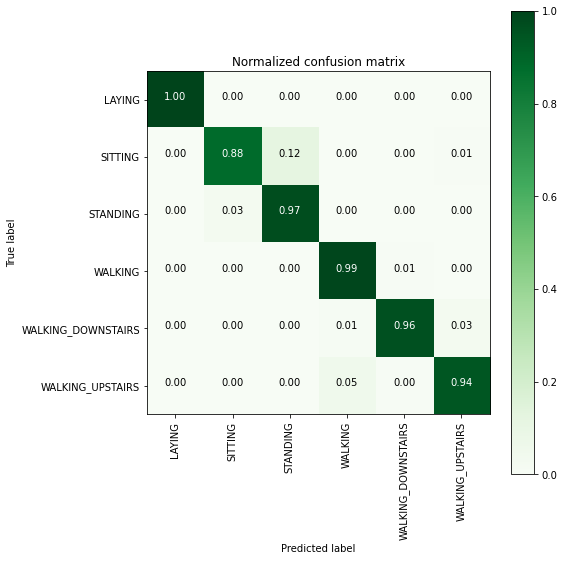

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.95      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.96      0.97       420
  WALKING_UPSTAIRS       0.96      0.94      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



In [11]:

# start Grid search
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test, class_labels=labels)


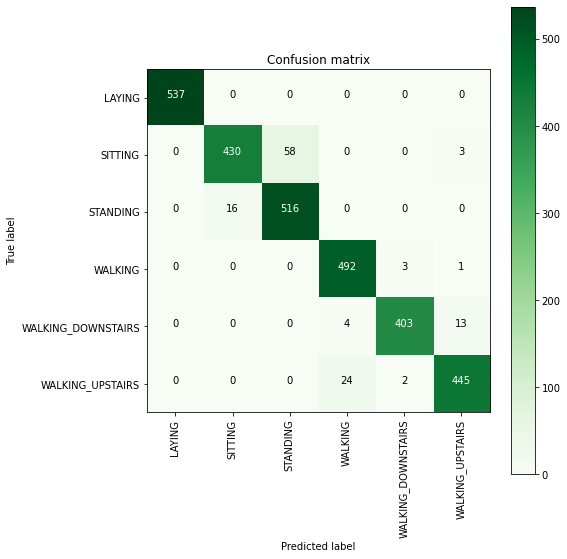

In [12]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [13]:
# observe the attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=1)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 1, 'penalty': 'l2'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 3

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9374335617559958



#  2. Linear SVC with GridSearch

In [14]:
from sklearn.svm import LinearSVC

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\tbresee\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Done 
 

training_time(HH:MM:SS.ms) - 0:00:20.666827


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.007005


---------------------
|      Accuracy      |
---------------------

    0.9664065151001018


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  2 427  58   0   0   4]
 [  0   9 522   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   3 412   5]
 [  0   0   0  17   0 454]]


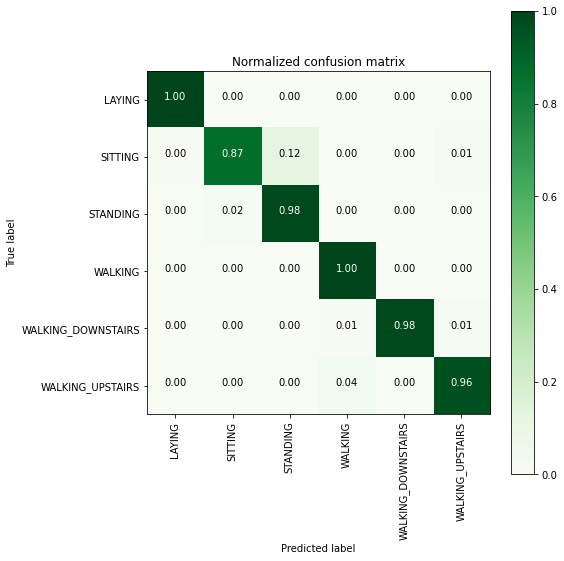

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.87      0.92       491
          STANDING       0.90      0.98      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947



In [15]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [16]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=0.5, tol=5e-05)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.5}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 5

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.9422003634900594



# 3. Decision Trees with GridSearchCV

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:05.143222


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.008001


---------------------
|      Accuracy      |
---------------------

    0.8751272480488632


--------------------
| Confusion Matrix |
--------------------

 [[537   0   0   0   0   0]
 [  0 368 123   0   0   0]
 [  0  60 472   0   0   0]
 [  0   0   0 471  19   6]
 [  0   0   0  22 351  47]
 [  0   0   0  65  26 380]]


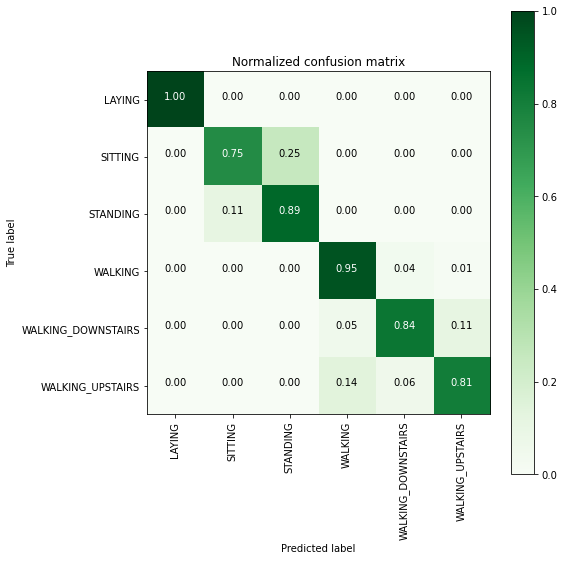

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.86      0.75      0.80       491
          STANDING       0.79      0.89      0.84       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.89      0.84      0.86       420
  WALKING_UPSTAIRS       0.88      0.81      0.84       471

          accuracy                           0.88      2947
         macro avg       0.88      0.87      0.87      2947
      weighted avg       0.88      0.88      0.87      2947

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(max_depth=9)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'max_depth': 9}

---------------------------------
|   No of CrossValidation sets

In [17]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])


# 4. Comparing all models

In [18]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%        {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 95.79%       4.208%
Linear SVC          : 96.64%       3.359% 
DecisionTree        : 87.51%        12.49% 


 ### ****We can choose ___Logistic regression___ or ___Linear SVC___ or try other classical algorithms.****

# Conclusion :

### In the real world, domain-knowledge, EDA and feature-engineering matter most.